In [101]:
# import the modules

import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
scorer = make_scorer(mean_squared_error, greater_is_better = False)

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
#from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abhineet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [102]:

nltk.download("stopwords")
from nltk.corpus import stopwords
# print (set(stopwords.words('english')))

from string import punctuation
#print (list(punctuation))

custom_set_of_stopwords = set(stopwords.words('english')+list(punctuation))
len(custom_set_of_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abhineet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


211

### Loading Train Data

In [103]:
train = pd.read_csv('Train.csv')
train = train.drop(['id','host_id','host_name'],1)
train.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Large private room in Nolita,Manhattan,Nolita,40.72217,-73.99481,Private room,120,7,3,2015-09-01,0.06,3,0
1,Super Bowl New York City Apartment,Manhattan,Upper West Side,40.80020,-73.96045,Entire home/apt,1500,1,0,NaN,NaN,1,0
2,COZY APT CLOSE TO LGA & JFK AND TRANSPORTATION,Queens,East Elmhurst,40.75558,-73.89316,Entire home/apt,200,2,4,2019-07-05,4.00,1,365
3,Stream-Pressed Paradise (Laundry Room Setup),Staten Island,Concord,40.60110,-74.07830,Shared room,30,2,0,NaN,NaN,4,82
4,Charming Harlem apartment,Manhattan,Harlem,40.81022,-73.94266,Shared room,115,1,16,2019-05-26,0.27,1,365


# EDA

In [104]:
train.shape
train.info()

train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34226 entries, 0 to 34225
Data columns (total 13 columns):
name                              34214 non-null object
neighbourhood_group               34226 non-null object
neighbourhood                     34226 non-null object
latitude                          34226 non-null float64
longitude                         34226 non-null float64
room_type                         34226 non-null object
price                             34226 non-null int64
minimum_nights                    34226 non-null int64
number_of_reviews                 34226 non-null int64
last_review                       27244 non-null object
reviews_per_month                 27244 non-null float64
calculated_host_listings_count    34226 non-null int64
availability_365                  34226 non-null int64
dtypes: float64(3), int64(5), object(5)
memory usage: 3.4+ MB


name                                12
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       6982
reviews_per_month                 6982
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [105]:
train.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,34226.000000,34226.000000,34226.000000,34226.000000,34226.000000,27244.000000,34226.000000,34226.000000
mean,40.729059,-73.952070,153.480979,6.953690,23.390931,1.377074,7.093905,113.301730
std,0.054604,0.046161,243.312608,20.255833,44.476822,1.688953,32.828412,131.892814
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690040,-73.983150,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.722995,-73.955700,107.000000,2.000000,5.000000,0.730000,1.000000,45.000000
75%,40.763200,-73.935982,175.000000,5.000000,24.000000,2.020000,2.000000,229.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Price column is highly skewed

### checking if last_review and reviews_per_month are null at the same rows, to confirm there were no reviews at all for those properties


In [106]:
nulls = train[train['last_review'].isnull() & train['reviews_per_month'].isnull()]

nulls.head()


,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1,Super Bowl New York City Apartment,Manhattan,Upper West Side,40.80020,-73.96045,Entire home/apt,1500,1,0,NaN,NaN,1,0
3,Stream-Pressed Paradise (Laundry Room Setup),Staten Island,Concord,40.60110,-74.07830,Shared room,30,2,0,NaN,NaN,4,82
7,Bright Luxury Apartment with Amazing View of City,Brooklyn,Fort Greene,40.69064,-73.97898,Entire home/apt,200,5,0,NaN,NaN,1,0
10,Private room for 2 in cool BK apt,Brooklyn,Kensington,40.64469,-73.97086,Private room,50,14,0,NaN,NaN,1,0
39,LUXURY DELUXE 2BR 2BATH -DOORMAN/GYM,Manhattan,Hell's Kitchen,40.76182,-73.99771,Entire home/apt,550,30,0,NaN,NaN,65,360


### Filling reviews_per_month null values with 0 and imputing last_review columns with null values with the earliest date present in the column

In [107]:
train['reviews_per_month'] = train['reviews_per_month'].fillna(0)
train['last_review'] = train['last_review'].fillna('2011-03-23')

### Binning is done on minimum_nights 

In [108]:
buckets = [0,7, 14,30, 60, 120, 240, train.minimum_nights.max()]
labels = [1,2,3,4, 5, 6, 7]
train['minimum_nights_buckets'] = pd.cut(train['minimum_nights'], bins=buckets, labels=labels)

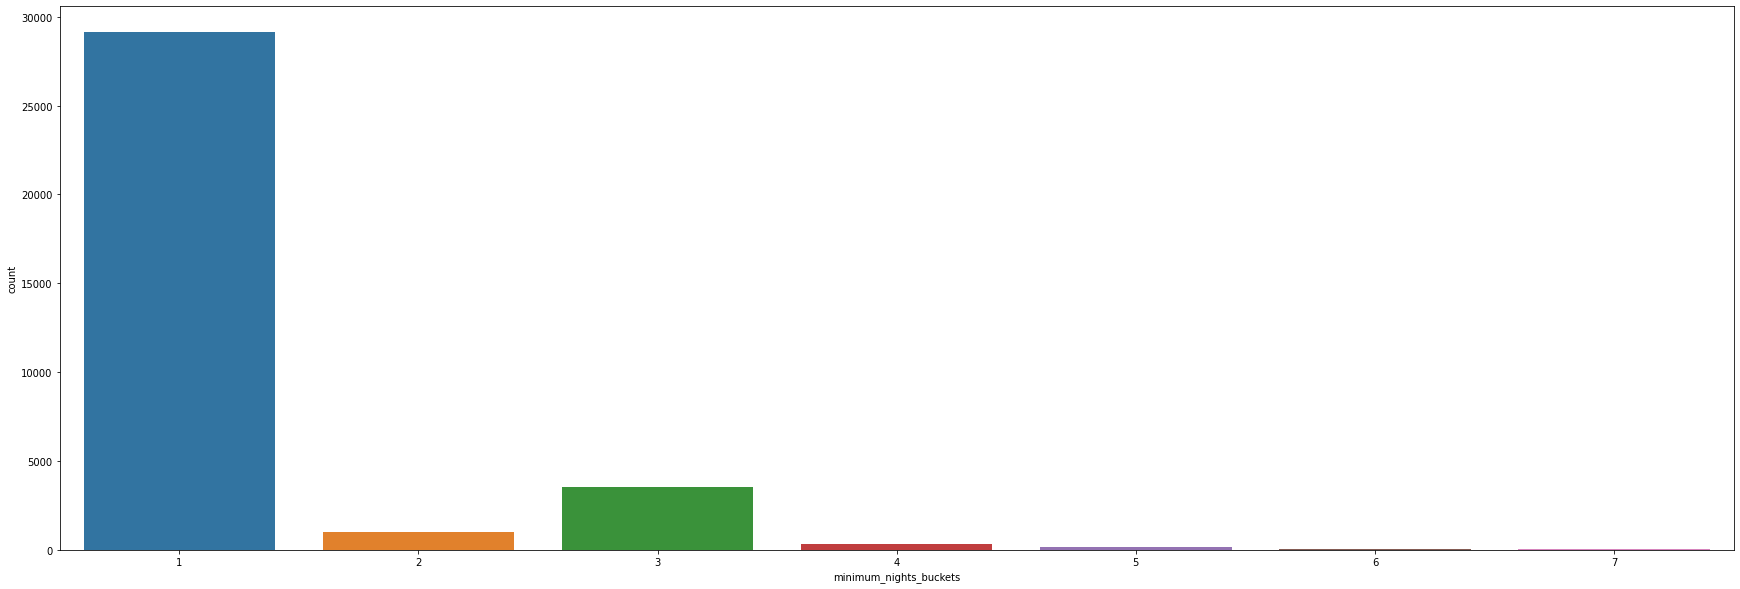

In [109]:
plt.figure(figsize=(30,10))
ax = sns.countplot(x="minimum_nights_buckets", data=train)

### Insight: 1-7 nights bookings are maximum bookings , second hightest booking is for 14-30 nights

<AxesSubplot:xlabel='minimum_nights_buckets', ylabel='count'>

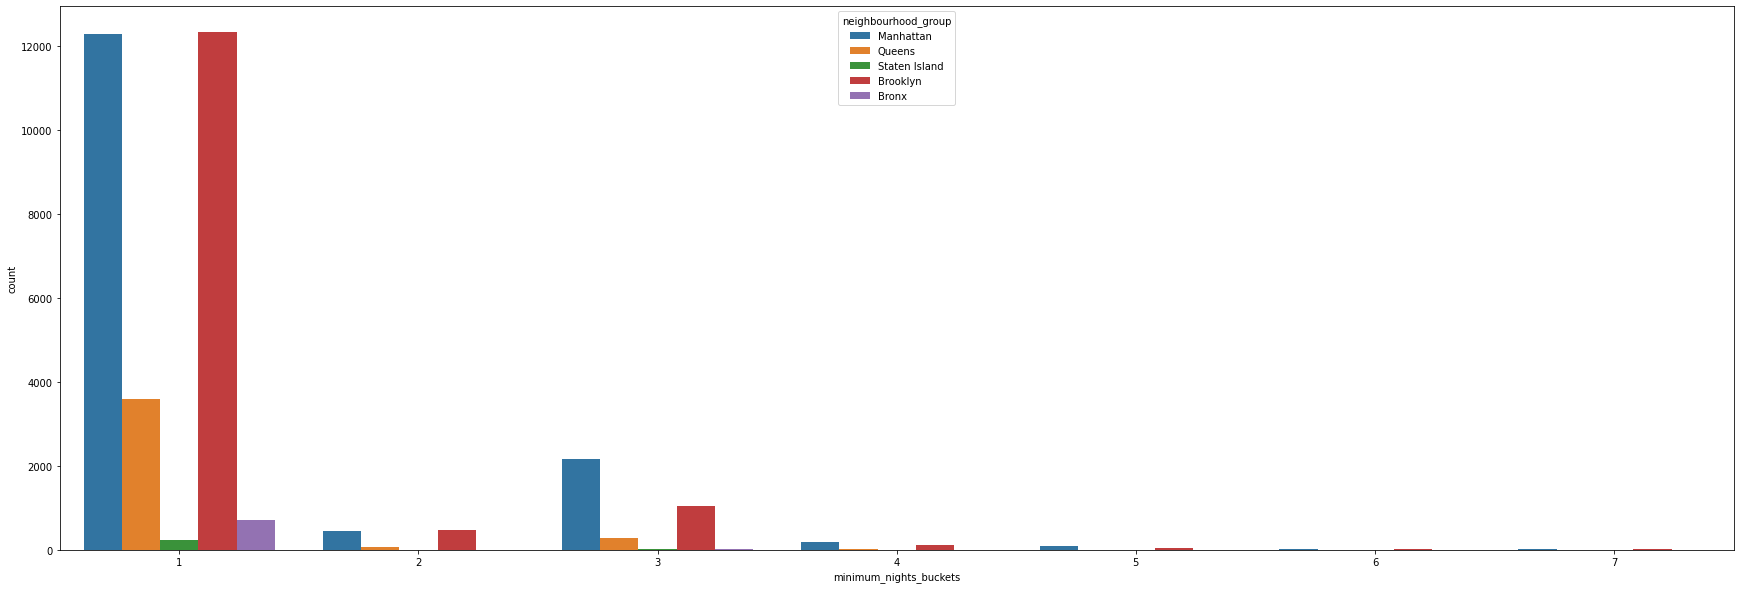

In [110]:
plt.figure(figsize=(30,10))
sns.countplot(x= 'minimum_nights_buckets',hue='neighbourhood_group', data = train)

### Insight: neighbourhood group 'Brooklyn' and 'Manhatten' has got most bookings for 1-7 nights

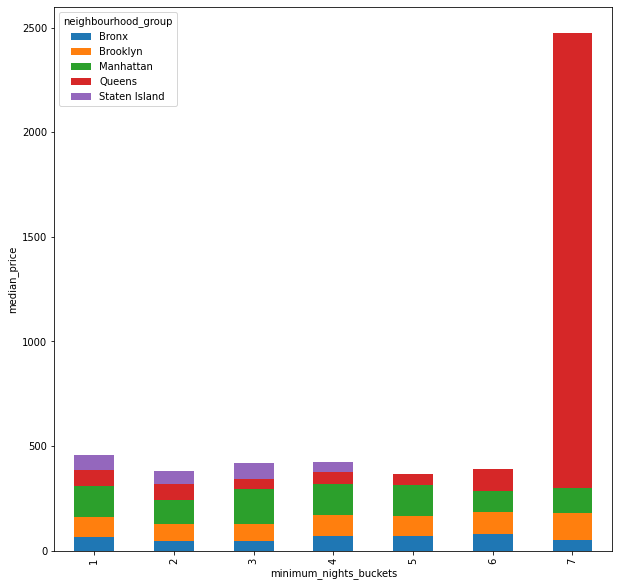

In [111]:
train.groupby(['minimum_nights_buckets', 'neighbourhood_group'])['price'].median().unstack().plot(kind='bar', stacked = True, figsize = (10,10))
plt.ylabel('median_price')
plt.show()

### adding a new columns 'days_last_review', to get days past since last review.

In [112]:
import datetime as dt

train['days_last_review'] = (pd.DatetimeIndex(train['last_review']) - pd.to_datetime('2011-03-23')).astype('str')
train['days_last_review'] = (train['days_last_review'].apply(lambda x : x.split(" ")[0]))


### Converting Latitude and Longitude columns into distance column and finally dropping Latitude and Longitude columns.

In [113]:
# The math module contains a function named
# radians which converts from degrees to radians.

from math import radians, cos, sin, asin, sqrt
def distance(lati1, lati2, long1, long2):
   
  long1 = radians(long1)
  long2 = radians(long2)
  lati1 = radians(lati1)
  lati2 = radians(lati2)
   
  # Haversine formula
  dlong = long2 - long1
  dlati = lati2 - lati1
  a = sin(dlati / 2)**2 + cos(lati1) * cos(lati2) * sin(dlong / 2)**2

  c = 2 * asin(sqrt(a))
 
  # Radius of earth in kilometers. Use 3956 for miles
  r = 6371
   
  # calculate the result
  return(c * r)
# print(distance(lati1, lati2, long1, long2), "K.M")
lati2 =round(train.latitude.values.mean(),2)
long2=round(train.longitude.values.mean(),2)
dist= []
for index,row in train.iterrows():
#     distance(row.latitude,lat2,row.longitude,lon2)
   dist.append(distance(row.latitude,lati2,row.longitude,long2))

#distance =distance(df.latitude.values,lat2,  df.longitude.values, df.longitude.values.mean())
train['distance']= pd.Series(dist)
train['distance'] = round(train['distance'],2)


### Dropping 'last_review','longitude','latitude' columns

In [114]:
train = train.drop(['last_review','longitude','latitude','minimum_nights'],1)
train.head()

,name,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,minimum_nights_buckets,days_last_review,distance
0,Large private room in Nolita,Manhattan,Nolita,Private room,120,3,0.06,3,0,1,1623,3.88
1,Super Bowl New York City Apartment,Manhattan,Upper West Side,Entire home/apt,1500,0,0.00,1,0,1,0,7.86
2,COZY APT CLOSE TO LGA & JFK AND TRANSPORTATION,Queens,East Elmhurst,Entire home/apt,200,4,4.00,1,365,1,3026,5.57
3,Stream-Pressed Paradise (Laundry Room Setup),Staten Island,Concord,Shared room,30,0,0.00,4,82,1,0,17.96
4,Charming Harlem apartment,Manhattan,Harlem,Shared room,115,16,0.27,1,365,1,2986,8.94


### Done some basic NLP task on the name column to remove uwanted words and remove punctuation etc.

In [116]:
train = train[train['name'].notnull()]

In [179]:
from sklearn.feature_extraction.text import CountVectorizer

def top_n_ngram(corpus,n = None,ngram = 1):
    vec = CountVectorizer(stop_words = 'english',ngram_range=(ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis =0) #Calculates the count of all the word in the whole review
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq[:n]
common_words = top_n_ngram(train['name'], 10,1)
df = pd.DataFrame(common_words, columns = ['text', 'count'])
plt.figure(figsize =(10,5))
plt.figure(figsize=(10,8))
sns.barplot(x = 'text', y = 'count', data = df )
plt.xticks(rotation = 45)
plt.title='Top 20 words in name column'
plt.show()

AttributeError: 'int' object has no attribute 'lower'

In [117]:
train['name'] = train['name'].str.lower()

import string

def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

train['name'] = train['name'].apply(lambda x:remove_punctuation(x))

def tok(text):
    tokenizer = word_tokenize(text)
    return tokenizer

train['name'] = train['name'].apply(lambda x:tok(x))    

def remove_stop_words(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['name'] = train['name'].apply(lambda x:remove_stop_words(x))

def join(text):
    joined = " ".join(text)
    return joined

train['name'] = train['name'].apply(lambda x:join(x))
train.head()


,name,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,minimum_nights_buckets,days_last_review,distance
0,large private room nolita,Manhattan,Nolita,Private room,120,3,0.06,3,0,1,1623,3.88
1,super bowl new york city apartment,Manhattan,Upper West Side,Entire home/apt,1500,0,0.00,1,0,1,0,7.86
2,cozy apt close lga jfk transportation,Queens,East Elmhurst,Entire home/apt,200,4,4.00,1,365,1,3026,5.57
3,streampressed paradise laundry room setup,Staten Island,Concord,Shared room,30,0,0.00,4,82,1,0,17.96
4,charming harlem apartment,Manhattan,Harlem,Shared room,115,16,0.27,1,365,1,2986,8.94


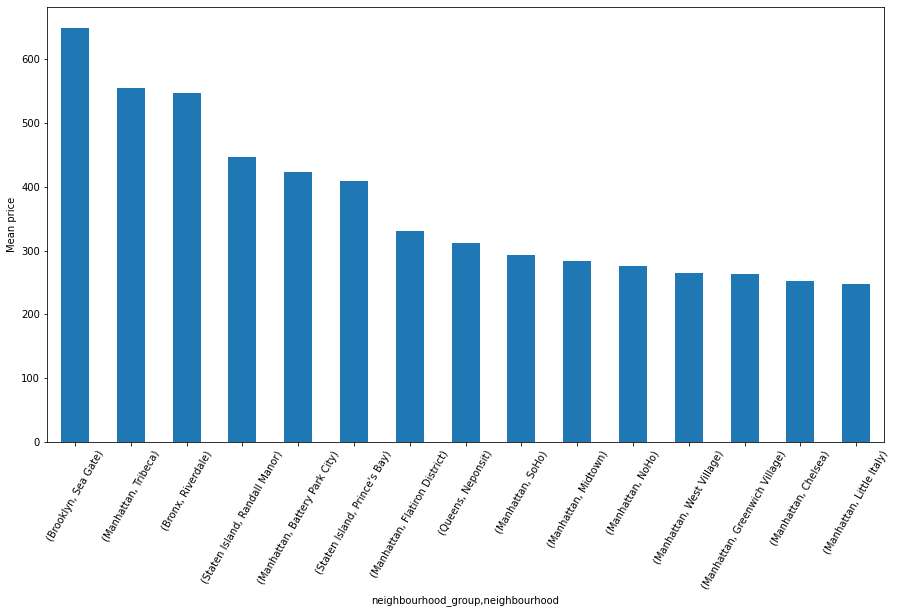

In [124]:
train.groupby(['neighbourhood_group'])['neighbourhood'].nunique()

plt.figure(figsize= (15,8))
data = train.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean().sort_values(ascending = False)[:15].plot(kind='bar')
plt.xticks(rotation = 60)
plt.ylabel('Mean price')
plt.show()

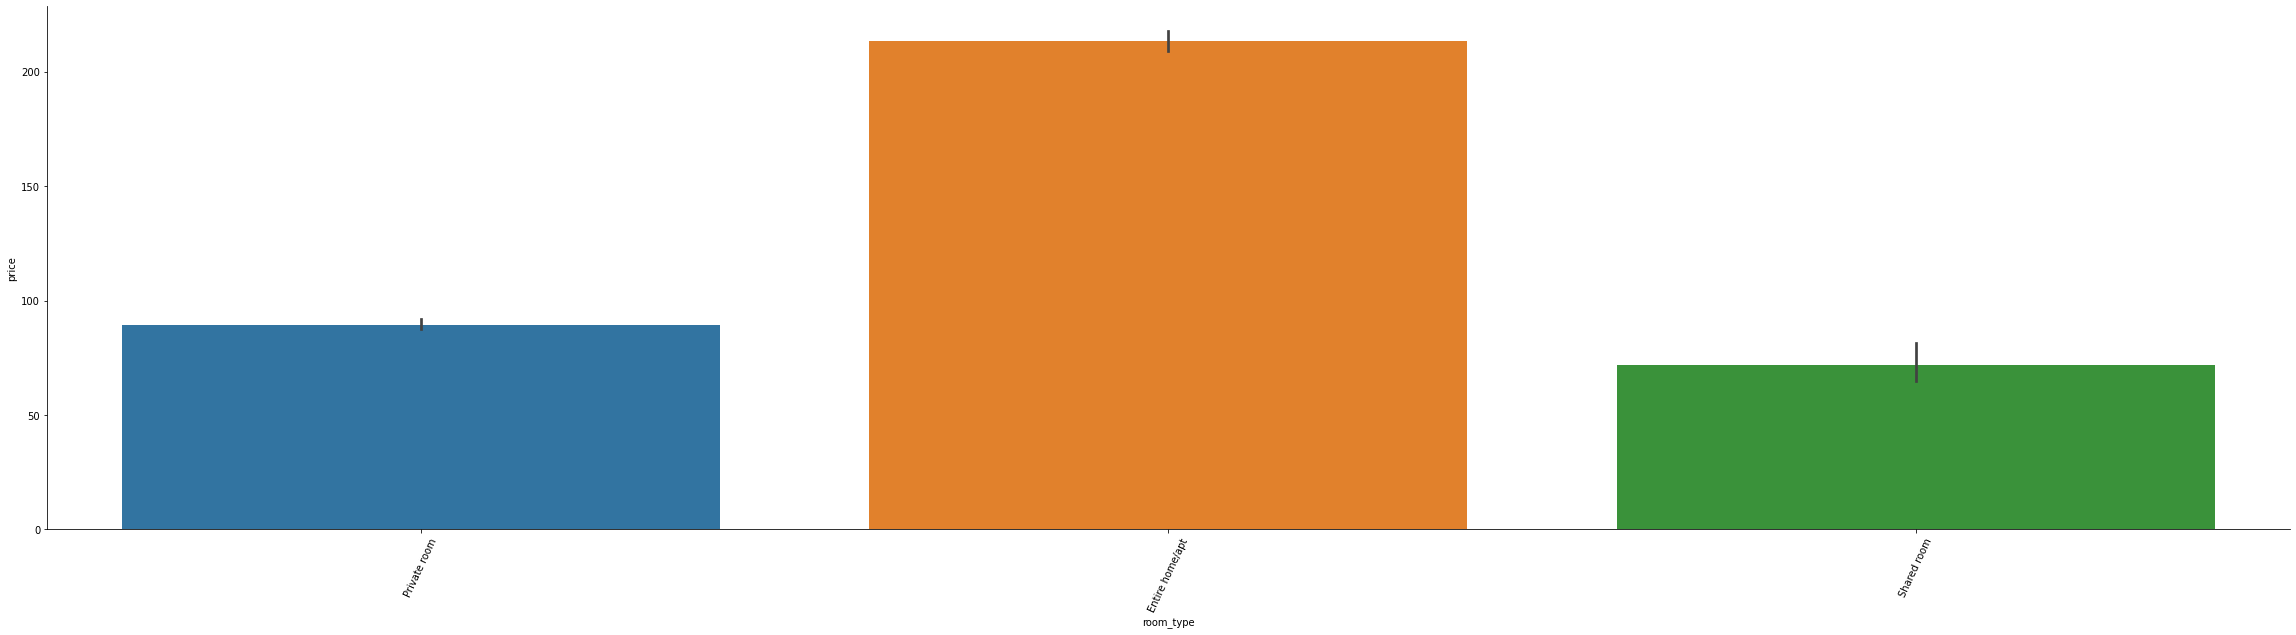

In [121]:
chart = sns.catplot(x='room_type' ,y='price', data=train , kind='bar', height=8, aspect=4,)
chart.set_xticklabels(rotation=65)
#chart.savefig('roomtype_vs_price.png',dpi=200,bbox_inches='tight')
#plt.savefig('out.png')

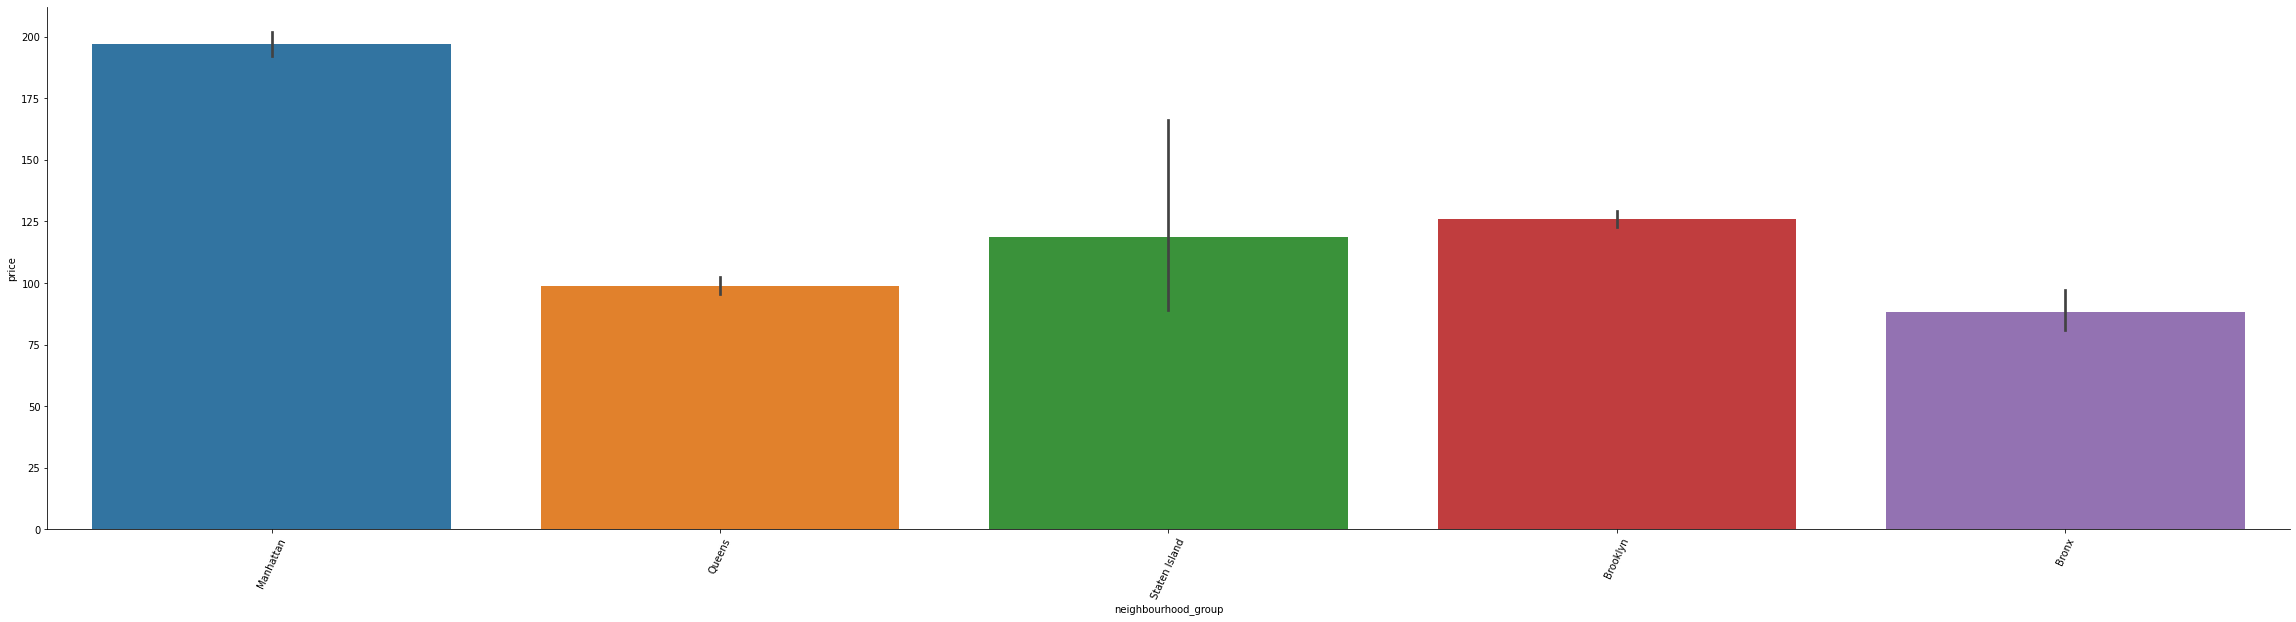

In [122]:
chart = sns.catplot(x='neighbourhood_group' ,y='price', data=train , kind='bar', height=8, aspect=4)
chart.set_xticklabels(rotation=65)
#chart.savefig('locality_vs_price.png',dpi=500,bbox_inches='tight')


In [ ]:
train.loc[train['availability_365']<train['minimum_nights'],'availability_365']=train['minimum_nights']
buckets = [0,50, 100,150, 200, 250, 300, train.availability_365.max()]
labels = [1,2,3,4, 5, 6, 7]
train['availability_365_buckets'] = pd.cut(train['availability_365'], labels=labels,bins=buckets,duplicates='drop')
data = train.groupby(['availability_365_buckets'])['price'].sum().reset_index()
plt.figure(figsize=(30,10))
sns.barplot(x= 'availability_365_buckets', y = 'price', data = data)

### Converting object columns into int values

In [125]:

categorical = train.select_dtypes(include='object')
for cols in categorical:
    train[cols] =train[cols].astype('category').cat.codes
    
train['minimum_nights_buckets'] = train['minimum_nights_buckets'].astype(int)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34214 entries, 0 to 34225
Data columns (total 12 columns):
name                              34214 non-null int32
neighbourhood_group               34214 non-null int8
neighbourhood                     34214 non-null int16
room_type                         34214 non-null int8
price                             34214 non-null int64
number_of_reviews                 34214 non-null int64
reviews_per_month                 34214 non-null float64
calculated_host_listings_count    34214 non-null int64
availability_365                  34214 non-null int64
minimum_nights_buckets            34214 non-null int32
days_last_review                  34214 non-null int16
distance                          34214 non-null float64
dtypes: float64(2), int16(2), int32(2), int64(4), int8(2)
memory usage: 3.5 MB


<AxesSubplot:xlabel='distance'>

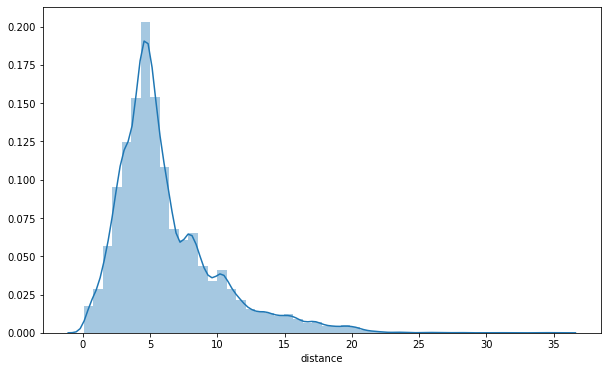

In [127]:
plt.figure(figsize=[10,6])

sns.distplot(train['distance'])

In [128]:
from scipy.stats import boxcox
train['distance'],lmbda = boxcox(train['distance'], lmbda=None)


<AxesSubplot:xlabel='distance'>

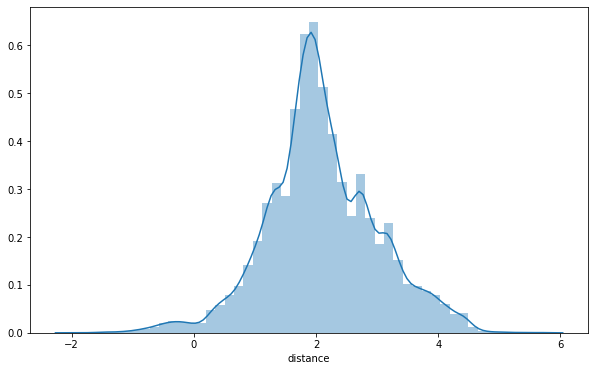

In [129]:
plt.figure(figsize=[10,6])

sns.distplot(train['distance'])

<AxesSubplot:xlabel='availability_365'>

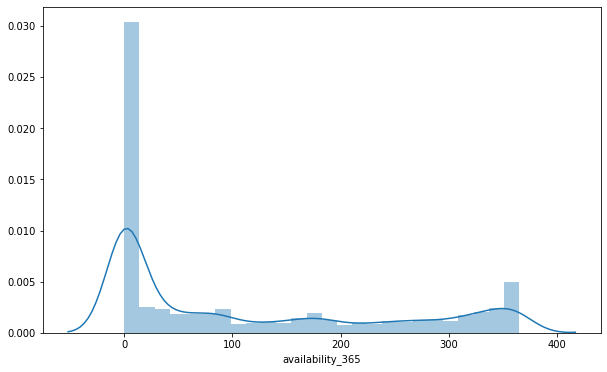

In [130]:
plt.figure(figsize=[10,6])

sns.distplot(train['availability_365'])

<AxesSubplot:xlabel='minimum_nights_buckets'>

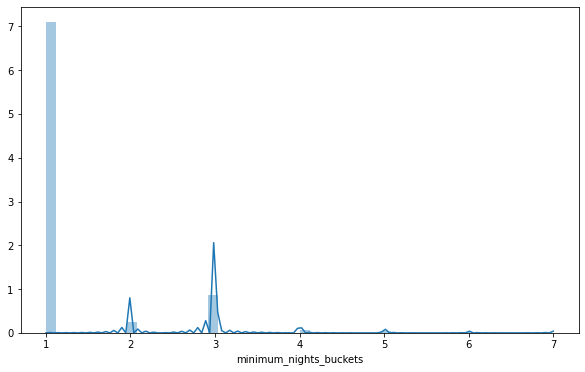

In [131]:
#checking skewness and treating them
plt.figure(figsize=[10,6])

#sns.distplot(train['name'])
sns.distplot(train['minimum_nights_buckets'])


<AxesSubplot:xlabel='number_of_reviews'>

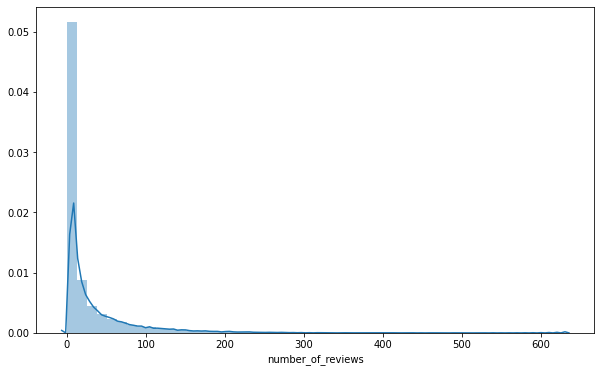

In [132]:
plt.figure(figsize=[10,6])

sns.distplot(train['number_of_reviews'])



In [133]:
train['number_of_reviews'] = np.log(train['number_of_reviews']+1)


<AxesSubplot:xlabel='number_of_reviews'>

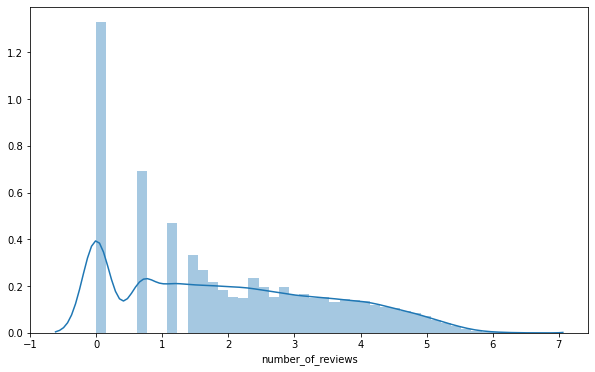

In [134]:
plt.figure(figsize=[10,6])

sns.distplot(train['number_of_reviews'])

<AxesSubplot:xlabel='reviews_per_month'>

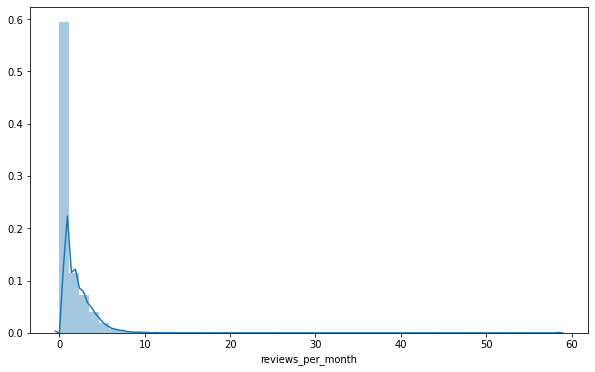

In [135]:
plt.figure(figsize=[10,6])

sns.distplot(train['reviews_per_month'])

In [136]:
train['reviews_per_month'] = np.log(train['reviews_per_month']+1)


<AxesSubplot:xlabel='reviews_per_month'>

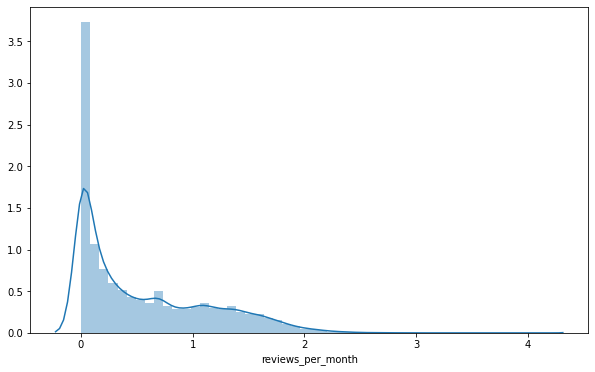

In [137]:
plt.figure(figsize=[10,6])

sns.distplot(train['reviews_per_month'])

<AxesSubplot:xlabel='calculated_host_listings_count'>

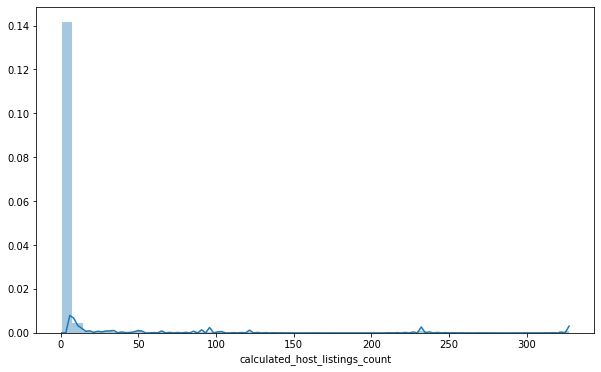

In [138]:
plt.figure(figsize=[10,6])

sns.distplot(train['calculated_host_listings_count'])

In [139]:
train['calculated_host_listings_count'] = np.log(train['calculated_host_listings_count']+1)

<AxesSubplot:xlabel='calculated_host_listings_count'>

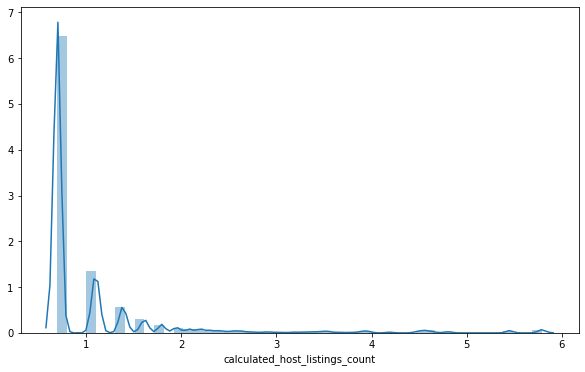

In [140]:
plt.figure(figsize=[10,6])

sns.distplot(train['calculated_host_listings_count'])

### Imputing columns with price 0 with median value

In [141]:
train['price'] = train['price'].replace(0,np.nan)
train['price'] = train['price'].fillna(train.groupby('neighbourhood')['price'].transform('median'))

### Looking for correlation if any among the features

<AxesSubplot:>

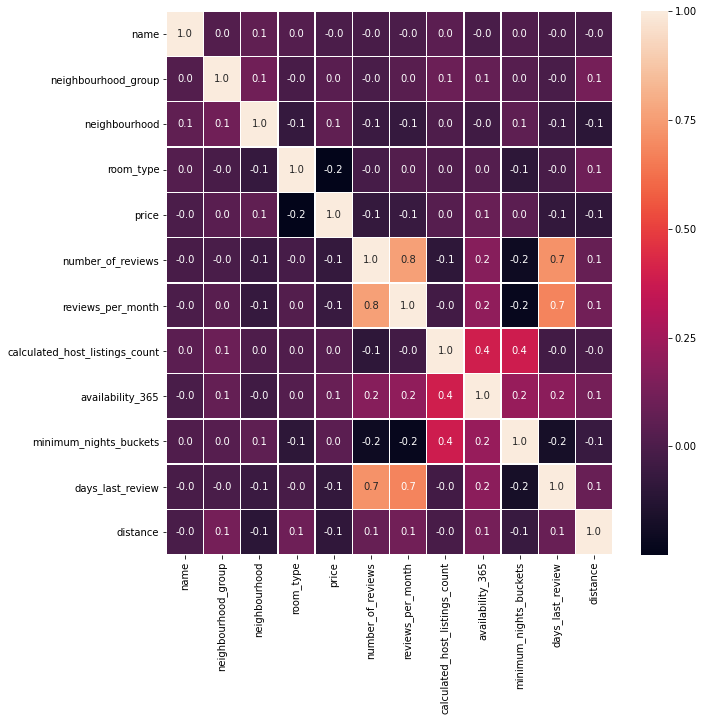

In [142]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train.corr(),annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### Plotting scatter plots to look for any correlation among the columns

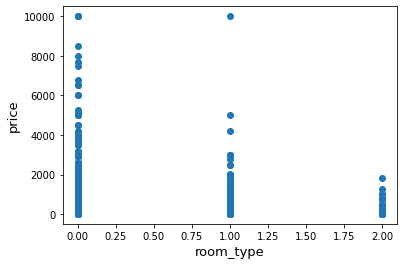

In [143]:
fig, ax = plt.subplots()
ax.scatter(x = train['room_type'], y = train['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('room_type', fontsize=13)
plt.show()

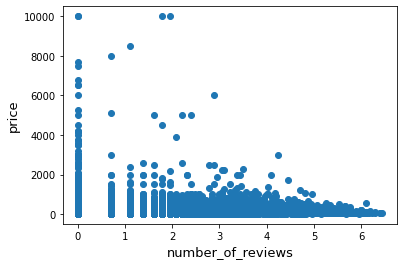

In [144]:
fig, ax = plt.subplots()
ax.scatter(x = train['number_of_reviews'], y = train['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('number_of_reviews', fontsize=13)
plt.show()

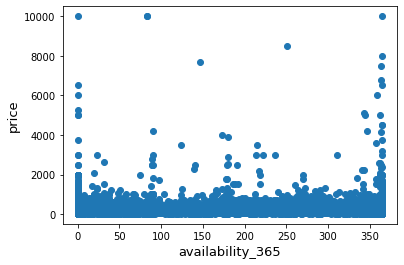

In [145]:
fig, ax = plt.subplots()
ax.scatter(x = train['availability_365'], y = train['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('availability_365', fontsize=13)
plt.show()

### Normalising the Price column and trying to reduce skewness


 mu = 153.51 and sigma = 243.33



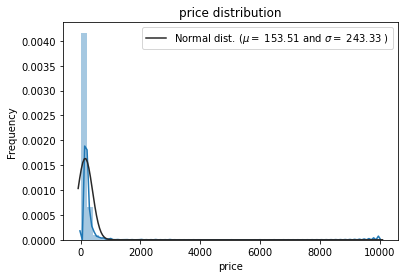

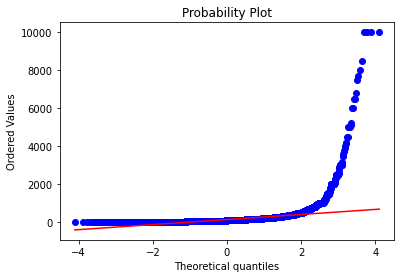

In [146]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()


 mu = 4.74 and sigma = 0.69



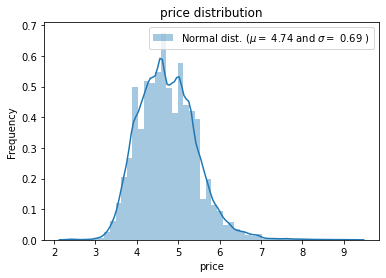

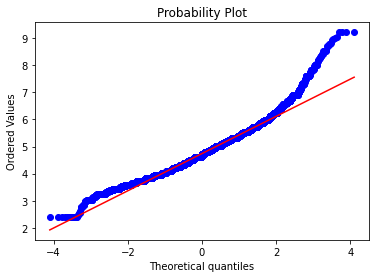

In [147]:
train["price"] = np.log1p(train["price"])

#Check the new distribution 
sns.distplot(train['price']);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

### Splitting dataset and creating Train and Test sets.

In [148]:
X = train.drop('price',1)
y = train['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

### Checking number of optimum features for modelling

In [149]:
from sklearn.feature_selection import RFECV

rf = RandomForestRegressor(random_state=43) 
rfecv = RFECV(estimator=rf, step=1, cv=5,scoring=scorer)   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 11
Best features : Index(['name', 'neighbourhood_group', 'neighbourhood', 'room_type',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'minimum_nights_buckets', 'days_last_review', 'distance'],
      dtype='object')


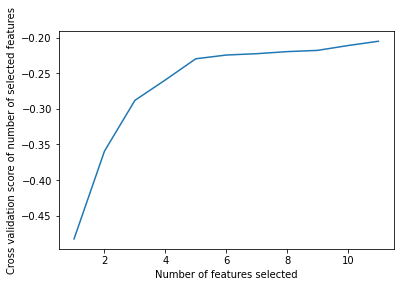

In [150]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### Modelling starts here

In [151]:
#LinearRegression Model

lmodel = LinearRegression()
lmodel.fit(X_train, y_train)

linearmo = lmodel.predict(X_test)
lrmse = np.sqrt(mean_squared_error(y_test, linearmo))
print(lrmse)
lin_acc = r2_score(y_test, linearmo)
lin_acc

0.5155379811110805


0.4495808699377545

In [152]:
#LinearRegression model with hyperparameter tuning

parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}

model = LinearRegression()
grid = GridSearchCV(model,parameters)

grid.fit(X_train, y_train)

pred = grid.predict(X_test)

square = mean_squared_error(y_test, pred)
rmse_2 = np.sqrt(square)
print(rmse_2)

raccuracy= r2_score(y_test, pred)
print(raccuracy)



0.515537981111081
0.4495808699377537


In [153]:
# plain RandomForestRegressor model

rf_clf1 = RandomForestRegressor(max_depth=2, random_state=2)
rf_clf1.fit(X_train, y_train)

prediction1 = rf_clf1.predict(X_test)


rf_square = mean_squared_error(y_test, prediction1)
rmse_rd = np.sqrt(rf_square)
print(rmse_rd)

rfaccuracy= r2_score(y_test, prediction1)
print(rfaccuracy)

0.5283613281911412
0.4218583825845069


In [154]:
#Modeling on linearRegression with PolynomialFeatures

from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X_train)

model.fit(x_poly,y_train)

x_testp = polynomial_features.fit_transform(X_test)
predd = model.predict(x_testp)

square = mean_squared_error(y_test, predd)
rmse_3 = np.sqrt(square)
print(rmse_3)

rs_accuracy= r2_score(y_test, predd)
rs_accuracy


0.4846035013767273


0.5136540742491427

In [155]:
##Lasso and Ridge with Hyperparameter tuning

lasso_lambdas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]

lasso_model = Lasso()
lasso_grid = GridSearchCV(lasso_model, param_grid=dict(alpha=lasso_lambdas), scoring=scorer ,cv=10)

lasso_grid.fit(X_train, y_train)
ls_pred = lasso_grid.predict(X_test)

lasso_rmse = np.sqrt(mean_squared_error(ls_pred, y_test))

print(lasso_rmse)
r2_score(ls_pred, y_test)

0.515530184996596


-0.2131204386428247

In [156]:
ridge_lambdas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]

ridge_model = Ridge()
Ridge_grid = GridSearchCV(ridge_model, param_grid=dict(alpha=ridge_lambdas), scoring=scorer )

Ridge_grid.fit(X_train, y_train)
rg_pred = Ridge_grid.predict(X_test)

ridge_rmse = np.sqrt(mean_squared_error(rg_pred, y_test))

print(ridge_rmse)
r2_score(rg_pred, y_test)

0.5155355285549835


-0.21262752389020356

In [157]:
#Modeling with standardisation of data

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

rf = RandomForestRegressor(max_depth=2, random_state=1)
rf.fit(X_train_scaled, y_train)

scaled_pred = rf.predict(X_test_scaled)

rff_rmse = np.sqrt(mean_squared_error(scaled_pred, y_test))
rff_rmse

0.5285573093255069

In [180]:
#Modelling with DecisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state = 4, max_depth=2)
dt.fit(X_train, y_train)
dtpredict = dt.predict(X_test)

dtrmse = np.sqrt(mean_squared_error(dtpredict, y_test))
dtrmse



0.5289033231684479

In [159]:
#Trying XGBoost

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:  1.1min finished


GridSearchCV(cv=2, estimator=XGBRegressor(), n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_weight': [4],
                         'n_estimators': [500], 'nthread': [4],
                         'objective': ['reg:linear'], 'silent': [1],
                         'subsample': [0.7]},
             verbose=True)

In [160]:
XGBPred = xgb_grid.predict(X_test)
XGB_rmse = np.sqrt(mean_squared_error(XGBPred, y_test))
print(XGB_rmse)
r2_score(XGBPred, y_test)

0.43096155272594666


0.36013901855281594

In [161]:
# Stacking Modelling

from mlxtend.regressor import StackingRegressor

classifier1 = LinearRegression()
classifier2= DecisionTreeRegressor(random_state=21)
classifier3 = Lasso(random_state=22)
classifier4= Ridge(random_state=23)
classifier5 = RandomForestRegressor(random_state=44)
classifier_list=[classifier1, classifier2, classifier3, classifier4, classifier5]

m_classifier=RandomForestRegressor(random_state=30)

# Code starts here
stack = StackingRegressor(regressors=classifier_list, meta_regressor=m_classifier)
stack.fit(X_train, y_train)
s_score = stack.predict(X_test)

stack_rmse = np.sqrt(mean_squared_error(y_test,s_score))
stack_rmse

0.6440468314621773

In [162]:
# GradientBoostingRegressor modelling

from sklearn.ensemble import GradientBoostingRegressor

gb_clf = GradientBoostingRegressor(random_state=0)

gb_clf.fit(X_train, y_train)
gb_score = gb_clf.predict(X_test)

rmsee = np.sqrt(mean_squared_error(y_test, gb_score))
print(rmsee)

r2_score(y_test, gb_score)

0.4531461843710469


0.5747455748364725

In [163]:
#Trying SVR

from sklearn.svm import SVR

svr_regressor = SVR(kernel='rbf')
svr_regressor.fit(X_train, y_train)
#5 Predicting a new result
y_pred_svr = svr_regressor.predict(X_test)
svr_rmse = np.sqrt(mean_squared_error(y_pred_svr, y_test))
print(svr_rmse)

r2_score(y_pred_svr, y_test)

0.681267643159255


-42.05634618581907

# Loading Test data and performing all above operations


In [164]:
test = pd.read_csv('test.csv')
test.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1525602,Perfect Temporary Brooklyn Home,1200603,Andrea,Brooklyn,Crown Heights,40.66751,-73.95867,Entire home/apt,2,121,2019-05-31,1.70,1,39
1,30430185,BIG APPLE - COMFY KING ROOM,224414117,Gabriel,Manhattan,Hell's Kitchen,40.75655,-73.99690,Private room,1,18,2019-05-05,2.49,30,364
2,21354525,Cozy Brooklyn Heights Getaway w/ Manhattan Access,11743513,Henry,Brooklyn,Brooklyn Heights,40.69252,-73.99121,Private room,1,87,2019-06-16,4.29,1,108
3,35995074,Amazing*Quiet*Sunny*Bedroom*PrivateLivingRm*Ch...,4128829,Sara,Queens,Ditmars Steinway,40.77292,-73.90101,Private room,9,0,NaN,NaN,2,365
4,34392081,Hello! This is a very cozy space in Williamsburg.,259630588,Alina,Brooklyn,Williamsburg,40.71863,-73.94980,Private room,1,28,2019-06-26,14.00,2,20


In [165]:
updated_test = test.drop(['id','host_id','host_name'],1)
updated_test.isnull().sum()

name                                 4
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
minimum_nights                       0
number_of_reviews                    0
last_review                       3070
reviews_per_month                 3070
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [166]:
updated_test.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,14669.000000,14669.000000,14669.000000,14669.000000,11599.000000,14669.000000,14669.000000
mean,40.728693,-73.952402,7.207921,23.002727,1.364172,7.260822,111.567114
std,0.054359,0.046148,21.092531,44.722549,1.660318,33.241116,130.985364
min,40.506410,-74.242850,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690160,-73.982890,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723220,-73.955640,3.000000,5.000000,0.700000,1.000000,44.000000
75%,40.762950,-73.936860,5.000000,23.000000,2.020000,2.000000,223.000000
max,40.908040,-73.716900,999.000000,594.000000,20.940000,327.000000,365.000000


In [167]:
updated_test['reviews_per_month'] = updated_test['reviews_per_month'].fillna(0)
updated_test['last_review'] = updated_test['last_review'].fillna('2011-03-23')

updated_test['days_last_review'] = (pd.DatetimeIndex(updated_test['last_review']) - pd.to_datetime('2011-03-23')).astype('str')
updated_test['days_last_review'] = (updated_test['days_last_review'].apply(lambda x : x.split(" ")[0]))


In [168]:
# The math module contains a function named
# radians which converts from degrees to radians.

from math import radians, cos, sin, asin, sqrt
def distance(lati1, lati2, long1, long2):
   
  long1 = radians(long1)
  long2 = radians(long2)
  lati1 = radians(lati1)
  lati2 = radians(lati2)
   
  # Haversine formula
  dlong = long2 - long1
  dlati = lati2 - lati1
  a = sin(dlati / 2)**2 + cos(lati1) * cos(lati2) * sin(dlong / 2)**2

  c = 2 * asin(sqrt(a))
 
  # Radius of earth in kilometers. Use 3956 for miles
  r = 6371
   
  # calculate the result
  return(c * r)
# print(distance(lati1, lati2, long1, long2), "K.M")
lati2 =round(updated_test.latitude.values.mean(),2)
long2=round(updated_test.longitude.values.mean(),2)
distt= []
for index,row in updated_test.iterrows():
#     distance(row.latitude,lat2,row.longitude,lon2)
   distt.append(distance(row.latitude,lati2,row.longitude,long2))

#distance =distance(df.latitude.values,lat2,  df.longitude.values, df.longitude.values.mean())
updated_test['distance_1']= pd.Series(dist)
updated_test['distance_1'] = round(updated_test['distance_1'],2)


In [170]:
updated_test['name'] = updated_test['name'].fillna(method='ffill')
updated_test.isnull().sum()

name                              0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
days_last_review                  0
distance_1                        0
dtype: int64

In [171]:
updated_test['name'] = updated_test['name'].str.lower()

import string

def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

updated_test['name'] = updated_test['name'].apply(lambda x:remove_punctuation(x))

def tok(text):
    tokenizer = word_tokenize(text)
    return tokenizer

updated_test['name'] = updated_test['name'].apply(lambda x:tok(x))    

def remove_stop_words(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

updated_test['name'] = updated_test['name'].apply(lambda x:remove_stop_words(x))

def join(text):
    joined = " ".join(text)
    return joined

updated_test['name'] = updated_test['name'].apply(lambda x:join(x))


In [172]:
buckets = [0,7, 14,30, 60, 120, 240, test.minimum_nights.max()]
labels = [1,2,3,4, 5, 6, 7]
updated_test['minimum_nights_buckets'] = pd.cut(updated_test['minimum_nights'], bins=buckets, labels=labels)

In [173]:
updated_test = updated_test.drop(['last_review','longitude','latitude','minimum_nights'],1)


In [174]:
categorical = updated_test.select_dtypes(include='object')
for cols in categorical:
    updated_test[cols] =updated_test[cols].astype('category').cat.codes
    
updated_test['minimum_nights_buckets'] = updated_test['minimum_nights_buckets'].astype(int)

In [175]:
updated_test['distance_1'],lmbda = boxcox(updated_test['distance_1'], lmbda=None)


In [176]:
colss = ['number_of_reviews','reviews_per_month','calculated_host_listings_count']

for i in colss:
    updated_test[i] = np.log(updated_test[i]+1)

<AxesSubplot:>

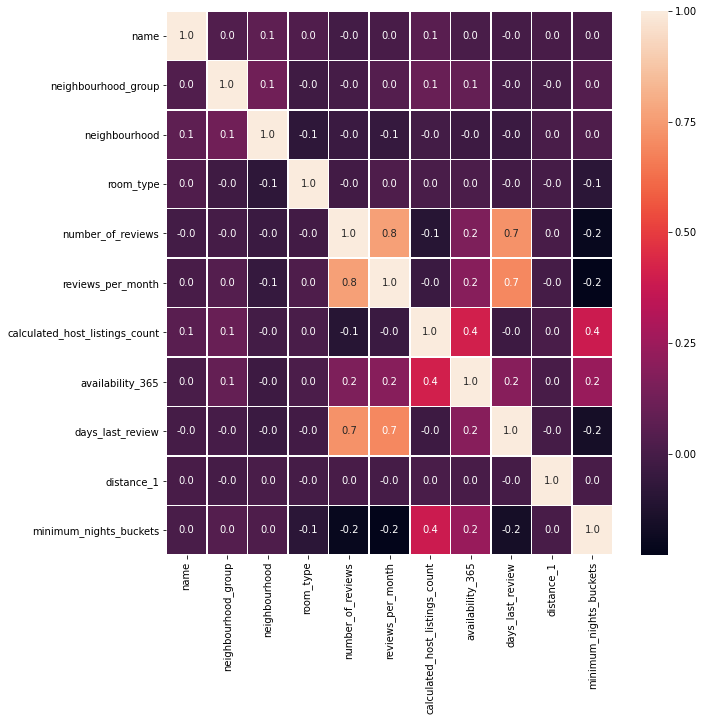

In [177]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(updated_test.corr(),annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [178]:
final_pred = gb_clf.predict(updated_test)
output = pd.DataFrame({'id': test.id, 'price': np.expm1(final_pred)})
output.to_csv('TEAM_4.csv', index=False)
output

,id,price
0,1525602,131.652722
1,30430185,97.110732
2,21354525,62.179902
3,35995074,154.592963
4,34392081,67.233471
...,...,...
14664,27730191,157.496668
14665,29676417,69.558529
14666,1813829,102.328798
14667,25017403,176.372805
